<a href="https://colab.research.google.com/github/DGkurnia/cnkproject/blob/main/%5BClustering%5D_DNA_Submission_Akhir_BMLP_Derfansyah_Guswiranata_Kurnia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Name : Derfansyah Guswiranata Kurnia
* Dicding ID : dgkurnia

# **1. Perkenalan Dataset**


Tahap pertama, Anda harus mencari dan menggunakan dataset **tanpa label** dengan ketentuan sebagai berikut:

1. **Sumber Dataset**:  
   Dataset dapat diperoleh dari berbagai sumber, seperti public repositories (*Kaggle*, *UCI ML Repository*, *Open Data*) atau data primer yang Anda kumpulkan sendiri.
   
2. **Ketentuan Dataset**:
   - **Tanpa label**: Dataset tidak boleh memiliki label atau kelas.
   - **Jumlah Baris**: Minimal 1000 baris untuk memastikan dataset cukup besar untuk analisis yang bermakna.
   - **Tipe Data**: Harus mengandung data **kategorikal** dan **numerikal**.
     - *Kategorikal*: Misalnya jenis kelamin, kategori produk.
     - *Numerikal*: Misalnya usia, pendapatan, harga.

3. **Pembatasan**:  
   Dataset yang sudah digunakan dalam latihan clustering (seperti customer segmentation) tidak boleh digunakan.

## Kaggle access

In [1]:
#Initiation from uploaded file
from google.colab import files
upload = files.upload()

Saving kaggle.json to kaggle (1).json


In [2]:
#downloading data from Kaggle (acess)
! pip install -q kaggle

In [3]:
#other metric
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
#permission
! chmod 600 ~/.kaggle/kaggle.json

## Data download

In [5]:
#first step: downloading from website
!kaggle datasets download -d kirkdco/protein-secondary-structure-2022

Dataset URL: https://www.kaggle.com/datasets/kirkdco/protein-secondary-structure-2022
License(s): DbCL-1.0
protein-secondary-structure-2022.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
#folder making
! mkdir dataset

mkdir: cannot create directory ‘dataset’: File exists


The data is stored in one folder

In [7]:
#Essential libraries for K-medoids (basics)
import numpy as np
import pandas as pd
#Graphic
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [8]:
#Interpolation
from scipy.interpolate import interp1d
#Pairwise
from sklearn.metrics import pairwise_distances
#quite extraction
import zipfile

In [9]:
#Part 2 (cluster preparation)
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import silhouette_score as ss #not ***ppi*

In [10]:
#Part 3 (Labeling and distance)
from sklearn.preprocessing import MultiLabelBinarizer as mlbin #for multi label analyzer
from sklearn.decomposition import PCA
from scipy.spatial import distance

In [11]:
#Inisiasi scaler
from sklearn.preprocessing import StandardScaler #in the PCA
from sklearn.preprocessing import RobustScaler #in Hierarchical
from sklearn.preprocessing import MinMaxScaler #in K-medoid

In [12]:
#instalasi gc
import gc

# **2. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [13]:
#google drive saving result
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
#Additional mandatory
from sklearn.utils import resample #resample
from concurrent.futures import ProcessPoolExecutor #Pool process
from scipy.spatial.distance import euclidean
from joblib import Memory #Memory

In [15]:
#DBSCAN
from sklearn.cluster import DBSCAN

In [51]:
#Additional mandatory in DBSCAN
from sklearn.decomposition import PCA
import plotly.express as px

In [ ]:
# the inisiation of Dill
! pip install dill
import dill

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 4.9 MB/s eta 0:00:00


# **3. Memuat Dataset**

Pada tahap ini, Anda perlu memuat dataset ke dalam notebook. Jika dataset dalam format CSV, Anda bisa menggunakan pustaka pandas untuk membacanya. Pastikan untuk mengecek beberapa baris awal dataset untuk memahami strukturnya dan memastikan data telah dimuat dengan benar.

Jika dataset berada di Google Drive, pastikan Anda menghubungkan Google Drive ke Colab terlebih dahulu. Setelah dataset berhasil dimuat, langkah berikutnya adalah memeriksa kesesuaian data dan siap untuk dianalisis lebih lanjut.

In [16]:
#inisiasi gc
gc.collect()

0

In [17]:
#quite extraction
with zipfile.ZipFile('/content/protein-secondary-structure-2022.zip', 'r', strict_timestamps=False) as zip_ref: # Replace with the actual zip file name
    zip_ref.extractall('./dataset') # File extraction

In [18]:
#Data preparation main
dfclean = pd.read_csv('/content/dataset/2022-08-03-ss.cleaned.csv')
dfcleank = dfclean.copy()

main component of cleaning

In [19]:
#inspection in main cleandf
print(dfcleank.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 477153 entries, 0 to 477152
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   pdb_id         477153 non-null  object
 1   chain_code     477153 non-null  object
 2   seq            477153 non-null  object
 3   sst8           477153 non-null  object
 4   sst3           477153 non-null  object
 5   len            477153 non-null  int64 
 6   has_nonstd_aa  477153 non-null  bool  
dtypes: bool(1), int64(1), object(5)
memory usage: 22.3+ MB
None


## Preparing the cutoff for data

In [20]:
#initiating gc
gc.collect()

0

In [21]:
#Data preparation (pc25 a2)
dfint1 = pd.read_csv('/content/dataset/2022-08-06-pdb-intersect-pisces_pc25_r2.0.csv')
dfint1k = dfint1.copy()
#info indataset
print(dfint1k.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7320 entries, 0 to 7319
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pdb_id         7320 non-null   object 
 1   chain_code     7320 non-null   object 
 2   seq            7320 non-null   object 
 3   sst8           7320 non-null   object 
 4   sst3           7320 non-null   object 
 5   len_x          7320 non-null   int64  
 6   has_nonstd_aa  7320 non-null   bool   
 7   len_y          7320 non-null   int64  
 8   method         7320 non-null   object 
 9   resol          7320 non-null   float64
 10  rfac           7320 non-null   float64
 11  freerfac       7259 non-null   float64
dtypes: bool(1), float64(3), int64(2), object(6)
memory usage: 636.3+ KB
None


In [22]:
#continuing the inspection 25 identity
dfint2 = pd.read_csv('/content/dataset/2022-08-06-pdb-intersect-pisces_pc25_r2.5.csv')
dfint2k = dfint2.copy()
#inspection
print(dfint2k.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9646 entries, 0 to 9645
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pdb_id         9646 non-null   object 
 1   chain_code     9646 non-null   object 
 2   seq            9646 non-null   object 
 3   sst8           9646 non-null   object 
 4   sst3           9646 non-null   object 
 5   len_x          9646 non-null   int64  
 6   has_nonstd_aa  9646 non-null   bool   
 7   len_y          9646 non-null   int64  
 8   method         9646 non-null   object 
 9   resol          9646 non-null   float64
 10  rfac           9646 non-null   float64
 11  freerfac       9562 non-null   float64
dtypes: bool(1), float64(3), int64(2), object(6)
memory usage: 838.5+ KB
None


In [23]:
#a2.5 in equal quality
dfint3 = pd.read_csv('/content/dataset/2022-08-06-pdb-intersect-pisces_pc30_r2.5.csv')
dfint3k = dfint3.copy()
#information check
print(dfint3k.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13406 entries, 0 to 13405
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pdb_id         13406 non-null  object 
 1   chain_code     13406 non-null  object 
 2   seq            13406 non-null  object 
 3   sst8           13406 non-null  object 
 4   sst3           13406 non-null  object 
 5   len_x          13406 non-null  int64  
 6   has_nonstd_aa  13406 non-null  bool   
 7   len_y          13406 non-null  int64  
 8   method         13406 non-null  object 
 9   resol          13406 non-null  float64
 10  rfac           13406 non-null  float64
 11  freerfac       13294 non-null  float64
dtypes: bool(1), float64(3), int64(2), object(6)
memory usage: 1.1+ MB
None


In [24]:
#continuing the dataset (identity 30%)
dfint4 = pd.read_csv('/content/dataset/2022-12-17-pdb-intersect-pisces_pc25_r2.0.csv')
dfint4k = dfint4.copy()
#information check
print(dfint4k.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8313 entries, 0 to 8312
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pdb_id         8313 non-null   object 
 1   chain_code     8313 non-null   object 
 2   seq            8313 non-null   object 
 3   sst8           8313 non-null   object 
 4   sst3           8313 non-null   object 
 5   len_x          8313 non-null   int64  
 6   has_nonstd_aa  8313 non-null   bool   
 7   len_y          8313 non-null   int64  
 8   method         8313 non-null   object 
 9   resol          8313 non-null   float64
 10  rfac           8313 non-null   float64
 11  freerfac       8252 non-null   float64
dtypes: bool(1), float64(3), int64(2), object(6)
memory usage: 722.6+ KB
None


In [25]:
#Data preparation (pc30)
dfint5 = pd.read_csv('/content/dataset/2022-12-17-pdb-intersect-pisces_pc25_r2.5.csv')
dfint5k = dfint5.copy()
#information check
print(dfint5k.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10931 entries, 0 to 10930
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pdb_id         10931 non-null  object 
 1   chain_code     10931 non-null  object 
 2   seq            10931 non-null  object 
 3   sst8           10931 non-null  object 
 4   sst3           10931 non-null  object 
 5   len_x          10931 non-null  int64  
 6   has_nonstd_aa  10931 non-null  bool   
 7   len_y          10931 non-null  int64  
 8   method         10931 non-null  object 
 9   resol          10931 non-null  float64
 10  rfac           10931 non-null  float64
 11  freerfac       10847 non-null  float64
dtypes: bool(1), float64(3), int64(2), object(6)
memory usage: 950.2+ KB
None


In [26]:
#final section
dfint6 = pd.read_csv('/content/dataset/2022-12-17-pdb-intersect-pisces_pc30_r2.5.csv')
dfint6k = dfint6.copy()
#inspection
print(dfint6k.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15079 entries, 0 to 15078
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pdb_id         15079 non-null  object 
 1   chain_code     15079 non-null  object 
 2   seq            15079 non-null  object 
 3   sst8           15079 non-null  object 
 4   sst3           15079 non-null  object 
 5   len_x          15079 non-null  int64  
 6   has_nonstd_aa  15079 non-null  bool   
 7   len_y          15079 non-null  int64  
 8   method         15079 non-null  object 
 9   resol          15079 non-null  float64
 10  rfac           15079 non-null  float64
 11  freerfac       14966 non-null  float64
dtypes: bool(1), float64(3), int64(2), object(6)
memory usage: 1.3+ MB
None


# **4. Exploratory Data Analysis (EDA)**

Pada tahap ini, Anda akan melakukan **Exploratory Data Analysis (EDA)** untuk memahami karakteristik dataset. EDA bertujuan untuk:

1. **Memahami Struktur Data**
   - Tinjau jumlah baris dan kolom dalam dataset.  
   - Tinjau jenis data di setiap kolom (numerikal atau kategorikal).

2. **Menangani Data yang Hilang**  
   - Identifikasi dan analisis data yang hilang (*missing values*). Tentukan langkah-langkah yang diperlukan untuk menangani data yang hilang, seperti pengisian atau penghapusan data tersebut.

3. **Analisis Distribusi dan Korelasi**  
   - Analisis distribusi variabel numerik dengan statistik deskriptif dan visualisasi seperti histogram atau boxplot.  
   - Periksa hubungan antara variabel menggunakan matriks korelasi atau scatter plot.

4. **Visualisasi Data**  
   - Buat visualisasi dasar seperti grafik distribusi dan diagram batang untuk variabel kategorikal.  
   - Gunakan heatmap atau pairplot untuk menganalisis korelasi antar variabel.

Tujuan dari EDA adalah untuk memperoleh wawasan awal yang mendalam mengenai data dan menentukan langkah selanjutnya dalam analisis atau pemodelan.

In [27]:
#other gc
gc.collect()

52

In [28]:
#Preparing a concatinated dataset from intersection
dfjune = pd.concat([dfint1k, dfint2k, dfint3k], verify_integrity=False, sort=True,copy=True)
dfjunek = dfjune.copy() #kopi dari data asli
#inspectng info
print(dfjunek.info())

<class 'pandas.core.frame.DataFrame'>
Index: 30372 entries, 0 to 13405
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   chain_code     30372 non-null  object 
 1   freerfac       30115 non-null  float64
 2   has_nonstd_aa  30372 non-null  bool   
 3   len_x          30372 non-null  int64  
 4   len_y          30372 non-null  int64  
 5   method         30372 non-null  object 
 6   pdb_id         30372 non-null  object 
 7   resol          30372 non-null  float64
 8   rfac           30372 non-null  float64
 9   seq            30372 non-null  object 
 10  sst3           30372 non-null  object 
 11  sst8           30372 non-null  object 
dtypes: bool(1), float64(3), int64(2), object(6)
memory usage: 2.8+ MB
None


data inspection in june

In [29]:
#data inspection in december
dfdec = pd.concat([dfint4k, dfint5k, dfint6k], verify_integrity=False, sort=True,copy=True)
dfdecek = dfdec.copy()
#inspecting info
print(dfdecek.info())

<class 'pandas.core.frame.DataFrame'>
Index: 34323 entries, 0 to 15078
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   chain_code     34323 non-null  object 
 1   freerfac       34065 non-null  float64
 2   has_nonstd_aa  34323 non-null  bool   
 3   len_x          34323 non-null  int64  
 4   len_y          34323 non-null  int64  
 5   method         34323 non-null  object 
 6   pdb_id         34323 non-null  object 
 7   resol          34323 non-null  float64
 8   rfac           34323 non-null  float64
 9   seq            34323 non-null  object 
 10  sst3           34323 non-null  object 
 11  sst8           34323 non-null  object 
dtypes: bool(1), float64(3), int64(2), object(6)
memory usage: 3.2+ MB
None


data inspection in december

In [30]:
#total inspection of intersection
dftotal = pd.concat([dfjunek, dfdecek], verify_integrity=False, sort=True,copy=True)
dftotalk = dftotal.copy()
#inspecting info
print(dftotalk.info())

<class 'pandas.core.frame.DataFrame'>
Index: 64695 entries, 0 to 15078
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   chain_code     64695 non-null  object 
 1   freerfac       64180 non-null  float64
 2   has_nonstd_aa  64695 non-null  bool   
 3   len_x          64695 non-null  int64  
 4   len_y          64695 non-null  int64  
 5   method         64695 non-null  object 
 6   pdb_id         64695 non-null  object 
 7   resol          64695 non-null  float64
 8   rfac           64695 non-null  float64
 9   seq            64695 non-null  object 
 10  sst3           64695 non-null  object 
 11  sst8           64695 non-null  object 
dtypes: bool(1), float64(3), int64(2), object(6)
memory usage: 6.0+ MB
None


total information

In [31]:
#peek
dftotalk.head(7)

,chain_code,freerfac,has_nonstd_aa,len_x,len_y,method,pdb_id,resol,rfac,seq,sst3,sst8
0,C,0.238,False,40,40,XRAY,2EQ7,1.800,0.207,LAMPAAERLMQEKGVSPAEVQGTGLGGRILKEDVMRHLEE,CCCHHHHHHHHHCCCCCCCCCCCCCCCCCCHHHHCCCCCC,CCCHHHHHHHHHTTCCTTTSCCCSSSSCCCHHHHTTCCCC
1,B,0.290,False,40,40,XRAY,3A1G,1.700,0.240,GGSMERIKELRNLMSQSRTREILTKTTVDHMAIIKKYTSG,CHHHHHHHHHHHHCCCHHHHHHHHHCECCHHHHHHHCCCC,CHHHHHHHHHHHHTTSHHHHHHHHHCBTTHHHHHHHTCCC
2,P,0.212,False,40,40,XRAY,3IFN,1.500,0.188,DAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVV,CCECCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,CCBCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
3,C,0.172,True,40,40,XRAY,3W19,1.278,0.156,*NNLLRAIEAQQHLLQLTVWGIKQLQARILAVERYLKDQ*,CCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCC,CCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCC
4,A,0.124,False,40,40,XRAY,4HGU,0.980,0.106,EAAVCTTEWDPVCGKDGKTYSNLCWLNEAGVGLDHEGECL,CCCCCCCCCCCEEECCCCEECCHHHHHHHCCCEEEECCCC,CCCCSCCCCCCEEETTSCEESSHHHHHHHTCCEEEESCCC
5,A,0.218,False,40,40,XRAY,4JNU,1.445,0.186,SYYIDADLLREIKQHLKQQQEGLSHLISIIKDDLEDIKLV,CCEEEHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHC,CCEEEHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHGGGC
6,X,0.201,False,40,40,XRAY,5B66,1.850,0.164,TITPSLKGFFIGLLSGAVVLGLTFAVLIAISQIDKVQRSL,CCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCCCCCCC,CCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHSCCCCCC


# **5. Data Preprocessing**

CPada tahap ini, data preprocessing adalah langkah penting untuk memastikan kualitas data sebelum digunakan dalam model machine learning. Data mentah sering kali mengandung nilai kosong, duplikasi, atau rentang nilai yang tidak konsisten, yang dapat memengaruhi kinerja model. Oleh karena itu, proses ini bertujuan untuk membersihkan dan mempersiapkan data agar analisis berjalan optimal.

Berikut adalah tahapan-tahapan yang perlu dilakukan, namun **tidak terbatas** pada:
1. Menghapus atau Menangani Data Kosong (Missing Values)
2. Menghapus Data Duplikat
3. Normalisasi atau Standarisasi Fitur
4. Deteksi dan Penanganan Outlier
5. Encoding Data Kategorikal
6. Binning (Pengelompokan Data)

In [32]:
#Clearing the duplicates
dfcleank.drop_duplicates()
dfcleank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 477153 entries, 0 to 477152
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   pdb_id         477153 non-null  object
 1   chain_code     477153 non-null  object
 2   seq            477153 non-null  object
 3   sst8           477153 non-null  object
 4   sst3           477153 non-null  object
 5   len            477153 non-null  int64 
 6   has_nonstd_aa  477153 non-null  bool  
dtypes: bool(1), int64(1), object(5)
memory usage: 22.3+ MB


In [33]:
#in totalk
dftotalk.drop_duplicates()
dftotalk.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64695 entries, 0 to 15078
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   chain_code     64695 non-null  object 
 1   freerfac       64180 non-null  float64
 2   has_nonstd_aa  64695 non-null  bool   
 3   len_x          64695 non-null  int64  
 4   len_y          64695 non-null  int64  
 5   method         64695 non-null  object 
 6   pdb_id         64695 non-null  object 
 7   resol          64695 non-null  float64
 8   rfac           64695 non-null  float64
 9   seq            64695 non-null  object 
 10  sst3           64695 non-null  object 
 11  sst8           64695 non-null  object 
dtypes: bool(1), float64(3), int64(2), object(6)
memory usage: 6.0+ MB


In [34]:
#preparing gc
gc.collect()

31

In [35]:
# Picking columns in totalk
selcoltot = dftotalk.iloc[:, [6,0,9,11,10,3,4,1,2,8]].copy() #No data slicing in original
selcoltot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64695 entries, 0 to 15078
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pdb_id         64695 non-null  object 
 1   chain_code     64695 non-null  object 
 2   seq            64695 non-null  object 
 3   sst8           64695 non-null  object 
 4   sst3           64695 non-null  object 
 5   len_x          64695 non-null  int64  
 6   len_y          64695 non-null  int64  
 7   freerfac       64180 non-null  float64
 8   has_nonstd_aa  64695 non-null  bool   
 9   rfac           64695 non-null  float64
dtypes: bool(1), float64(2), int64(2), object(5)
memory usage: 5.0+ MB


Important datas in cluster
- len_x and len_y for length
- confirmation of **non-standard** amino acid
- the value of rfac

## Initiating data cleaning

In [36]:
#selecting freerfac in dftotalk
frfacv = dftotalk.iloc[:,1].copy()
frfacv.info()

<class 'pandas.core.series.Series'>
Index: 64695 entries, 0 to 15078
Series name: freerfac
Non-Null Count  Dtype  
--------------  -----  
64180 non-null  float64
dtypes: float64(1)
memory usage: 1010.9 KB


In [37]:
#inspecting missing column in selcoltot
selcoltot.isnull().sum()

,0
pdb_id,0
chain_code,0
seq,0
sst8,0
sst3,0
len_x,0
len_y,0
freerfac,515
has_nonstd_aa,0
rfac,0


In [38]:
#reconcatening the colum
selcoltot['freerfac'] = frfacv

In [41]:
#fixing the value by interpolation
selcoltot['freerfac'] = selcoltot['freerfac'].interpolate(method = 'nearest', limit_direction = 'forward')

In [42]:
#inspecting after erasure
selcoltot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64695 entries, 0 to 15078
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pdb_id         64695 non-null  object 
 1   chain_code     64695 non-null  object 
 2   seq            64695 non-null  object 
 3   sst8           64695 non-null  object 
 4   sst3           64695 non-null  object 
 5   len_x          64695 non-null  int64  
 6   len_y          64695 non-null  int64  
 7   freerfac       64695 non-null  float64
 8   has_nonstd_aa  64695 non-null  bool   
 9   rfac           64695 non-null  float64
dtypes: bool(1), float64(2), int64(2), object(5)
memory usage: 5.0+ MB


In [43]:
#blending the dataset
mergeddf = pd.merge(dfcleank, selcoltot, on='pdb_id', how='inner', copy=True, sort=True)
mergeddfk = mergeddf.copy()
#inspecting result
print(mergeddfk.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140963 entries, 0 to 140962
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   pdb_id           140963 non-null  object 
 1   chain_code_x     140963 non-null  object 
 2   seq_x            140963 non-null  object 
 3   sst8_x           140963 non-null  object 
 4   sst3_x           140963 non-null  object 
 5   len              140963 non-null  int64  
 6   has_nonstd_aa_x  140963 non-null  bool   
 7   chain_code_y     140963 non-null  object 
 8   seq_y            140963 non-null  object 
 9   sst8_y           140963 non-null  object 
 10  sst3_y           140963 non-null  object 
 11  len_x            140963 non-null  int64  
 12  len_y            140963 non-null  int64  
 13  freerfac         140963 non-null  float64
 14  has_nonstd_aa_y  140963 non-null  bool   
 15  rfac             140963 non-null  float64
dtypes: bool(2), float64(2), int64(3), obje

In [44]:
#initiating gc
gc.collect()

3015

In [45]:
#inspecting samples
mergeddfk.head(7)

,pdb_id,chain_code_x,seq_x,sst8_x,sst3_x,len,has_nonstd_aa_x,chain_code_y,seq_y,sst8_y,sst3_y,len_x,len_y,freerfac,has_nonstd_aa_y,rfac
0,12AS,A,MKTAYIAKQRQISFVKSHFSRQLEERLGLIEVQAPILSRVGDGTQD...,CCCCHHHHHHHHHHHHHHHHHHHHHHHCEEECCCCSEEETTSSCSC...,CCCCHHHHHHHHHHHHHHHHHHHHHHHCEEECCCCCEEECCCCCCC...,330,False,A,MKTAYIAKQRQISFVKSHFSRQLEERLGLIEVQAPILSRVGDGTQD...,CCCCHHHHHHHHHHHHHHHHHHHHHHHCEEECCCCSEEETTSSCSC...,CCCCHHHHHHHHHHHHHHHHHHHHHHHCEEECCCCCEEECCCCCCC...,330,330,0.287,False,0.164
1,12AS,A,MKTAYIAKQRQISFVKSHFSRQLEERLGLIEVQAPILSRVGDGTQD...,CCCCHHHHHHHHHHHHHHHHHHHHHHHCEEECCCCSEEETTSSCSC...,CCCCHHHHHHHHHHHHHHHHHHHHHHHCEEECCCCCEEECCCCCCC...,330,False,A,MKTAYIAKQRQISFVKSHFSRQLEERLGLIEVQAPILSRVGDGTQD...,CCCCHHHHHHHHHHHHHHHHHHHHHHHCEEECCCCSEEETTSSCSC...,CCCCHHHHHHHHHHHHHHHHHHHHHHHCEEECCCCCEEECCCCCCC...,330,330,0.287,False,0.164
2,12AS,A,MKTAYIAKQRQISFVKSHFSRQLEERLGLIEVQAPILSRVGDGTQD...,CCCCHHHHHHHHHHHHHHHHHHHHHHHCEEECCCCSEEETTSSCSC...,CCCCHHHHHHHHHHHHHHHHHHHHHHHCEEECCCCCEEECCCCCCC...,330,False,A,AYIAKQRQISFVKSHFSRQLEERLGLIEVQAPILSRVGDGTQDNLS...,CHHHHHHHHHHHHHHHHHHHHHHHCEEECCCCSEEETTSSCSCCTT...,CHHHHHHHHHHHHHHHHHHHHHHHCEEECCCCCEEECCCCCCCCCC...,327,327,0.287,False,0.164
3,12AS,A,MKTAYIAKQRQISFVKSHFSRQLEERLGLIEVQAPILSRVGDGTQD...,CCCCHHHHHHHHHHHHHHHHHHHHHHHCEEECCCCSEEETTSSCSC...,CCCCHHHHHHHHHHHHHHHHHHHHHHHCEEECCCCCEEECCCCCCC...,330,False,A,AYIAKQRQISFVKSHFSRQLEERLGLIEVQAPILSRVGDGTQDNLS...,CHHHHHHHHHHHHHHHHHHHHHHHCEEECCCCSEEETTSSCSCCTT...,CHHHHHHHHHHHHHHHHHHHHHHHCEEECCCCCEEECCCCCCCCCC...,327,327,0.287,False,0.164
4,12AS,B,MKTAYIAKQRQISFVKSHFSRQLEERLGLIEVQAPILSRVGDGTQD...,CCCCHHHHHHHHHHHHHHHHHHHHHHSCEEECCCCSEEETTSSCSC...,CCCCHHHHHHHHHHHHHHHHHHHHHHCCEEECCCCCEEECCCCCCC...,330,False,A,MKTAYIAKQRQISFVKSHFSRQLEERLGLIEVQAPILSRVGDGTQD...,CCCCHHHHHHHHHHHHHHHHHHHHHHHCEEECCCCSEEETTSSCSC...,CCCCHHHHHHHHHHHHHHHHHHHHHHHCEEECCCCCEEECCCCCCC...,330,330,0.287,False,0.164
5,12AS,B,MKTAYIAKQRQISFVKSHFSRQLEERLGLIEVQAPILSRVGDGTQD...,CCCCHHHHHHHHHHHHHHHHHHHHHHSCEEECCCCSEEETTSSCSC...,CCCCHHHHHHHHHHHHHHHHHHHHHHCCEEECCCCCEEECCCCCCC...,330,False,A,MKTAYIAKQRQISFVKSHFSRQLEERLGLIEVQAPILSRVGDGTQD...,CCCCHHHHHHHHHHHHHHHHHHHHHHHCEEECCCCSEEETTSSCSC...,CCCCHHHHHHHHHHHHHHHHHHHHHHHCEEECCCCCEEECCCCCCC...,330,330,0.287,False,0.164
6,12AS,B,MKTAYIAKQRQISFVKSHFSRQLEERLGLIEVQAPILSRVGDGTQD...,CCCCHHHHHHHHHHHHHHHHHHHHHHSCEEECCCCSEEETTSSCSC...,CCCCHHHHHHHHHHHHHHHHHHHHHHCCEEECCCCCEEECCCCCCC...,330,False,A,AYIAKQRQISFVKSHFSRQLEERLGLIEVQAPILSRVGDGTQDNLS...,CHHHHHHHHHHHHHHHHHHHHHHHCEEECCCCSEEETTSSCSCCTT...,CHHHHHHHHHHHHHHHHHHHHHHHCEEECCCCCEEECCCCCCCCCC...,327,327,0.287,False,0.164


In [47]:
#selecting potential columns
potcol = mergeddfk.iloc[:,[0,1,7,6,13,11,12,15,14]].copy()
#inspecting result
print(potcol.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140963 entries, 0 to 140962
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   pdb_id           140963 non-null  object 
 1   chain_code_x     140963 non-null  object 
 2   chain_code_y     140963 non-null  object 
 3   has_nonstd_aa_x  140963 non-null  bool   
 4   freerfac         140963 non-null  float64
 5   len_x            140963 non-null  int64  
 6   len_y            140963 non-null  int64  
 7   rfac             140963 non-null  float64
 8   has_nonstd_aa_y  140963 non-null  bool   
dtypes: bool(2), float64(2), int64(2), object(3)
memory usage: 7.8+ MB
None


# **6. Pembangunan Model Clustering**

## **a. Pembangunan Model Clustering**

Pada tahap ini, Anda membangun model clustering dengan memilih algoritma yang sesuai untuk mengelompokkan data berdasarkan kesamaan. Berikut adalah **rekomendasi** tahapannya.
1. Pilih algoritma clustering yang sesuai.
2. Latih model dengan data menggunakan algoritma tersebut.

In [48]:
#picking all numerical column
bhnclst = potcol.select_dtypes(include='number').copy()
#inspection
print(bhnclst.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140963 entries, 0 to 140962
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   freerfac  140963 non-null  float64
 1   len_x     140963 non-null  int64  
 2   len_y     140963 non-null  int64  
 3   rfac      140963 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 4.3 MB
None


The code (**bhnclst**) is for clustering

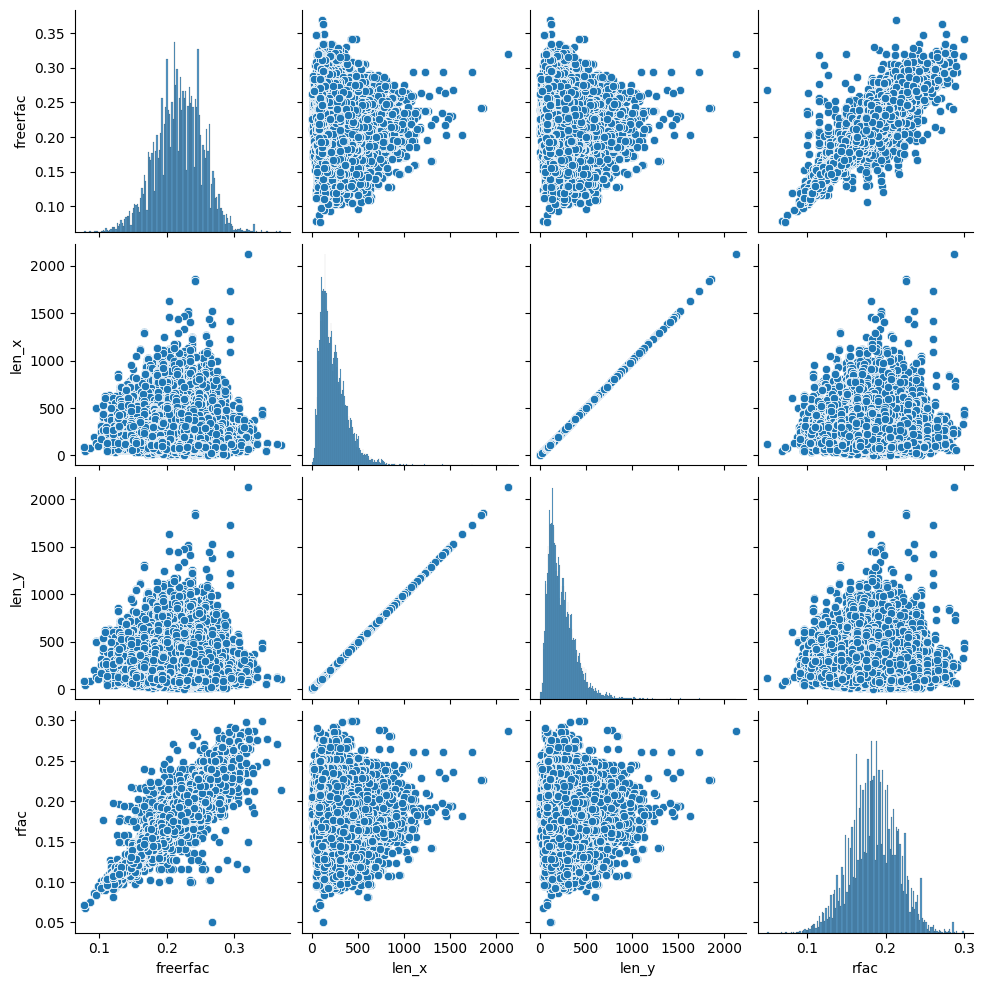

In [50]:
#inspecting pair plot
sns.pairplot(bhnclst)
plt.show()

## **b. Evaluasi Model Clustering**

Untuk menentukan jumlah cluster yang optimal dalam model clustering, Anda dapat menggunakan metode Elbow atau Silhouette Score.

Metode ini membantu kita menemukan jumlah cluster yang memberikan pemisahan terbaik antar kelompok data, sehingga model yang dibangun dapat lebih efektif. Berikut adalah **rekomendasi** tahapannya.
1. Gunakan Silhouette Score dan Elbow Method untuk menentukan jumlah cluster optimal.
2. Hitung Silhouette Score sebagai ukuran kualitas cluster.

In [ ]:
#Type your code here

## **c. Feature Selection (Opsional)**

Silakan lakukan feature selection jika Anda membutuhkan optimasi model clustering. Jika Anda menerapkan proses ini, silakan lakukan pemodelan dan evaluasi kembali menggunakan kolom-kolom hasil feature selection. Terakhir, bandingkan hasil performa model sebelum dan sesudah menerapkan feature selection.

In [ ]:
#Type your code here

## **d. Visualisasi Hasil Clustering**

Setelah model clustering dilatih dan jumlah cluster optimal ditentukan, langkah selanjutnya adalah menampilkan hasil clustering melalui visualisasi.

Berikut adalah **rekomendasi** tahapannya.
1. Tampilkan hasil clustering dalam bentuk visualisasi, seperti grafik scatter plot atau 2D PCA projection.

In [ ]:
#Type your code here

## **e. Analisis dan Interpretasi Hasil Cluster**

Setelah melakukan clustering, langkah selanjutnya adalah menganalisis karakteristik dari masing-masing cluster berdasarkan fitur yang tersedia.

Berikut adalah **rekomendasi** tahapannya.
1. Analisis karakteristik tiap cluster berdasarkan fitur yang tersedia (misalnya, distribusi nilai dalam cluster).
2. Berikan interpretasi: Apakah hasil clustering sesuai dengan ekspektasi dan logika bisnis? Apakah ada pola tertentu yang bisa dimanfaatkan?

In [ ]:
#Type your code here

Tulis hasil interpretasinya di sini.
1. Cluster 1:
2. Cluster 2:
3. Cluster 3:

# **7. Mengeksport Data**

Simpan hasilnya ke dalam file CSV.